---
title: "TAOPIOCA acoustic data initial exploration"
author: "Gaspard Ringuenet"
---

In [ ]:
# Imports
import os

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Local imports
from src.exploration.io import load_survey_ds, print_file_infos
from src.exploration.visualization import plot_survey_map, plot_sv_channels_faceted, plot_3d_scatter, plot_hexbin_2d, plot_hist
from src.exploration.processing import ds_to_sv, filter_depth, get_ch_list, compute_differences, flatten_valid, sample_safe

# Hyperparameters
EI = "amazomix_3pings1m"    # which survey to use as input (see src.exploration.data_config.py)
FORCE_PLOT = False               # whether to plot even if the image file already exists in notebooks/output/
SV_THRESHOLD = -120             # threshold for min Sv (accross channels), in dB. ESUs with one channel below threshold are removed from analyses
N_SAMPLES = 100_000             # number of samples for Sv differences distribution plots   

In [ ]:
# Load survey and print basic information
ds = load_survey_ds(EI)
print_file_infos(ds)

* Title:	Acoustic along the BRAzilian COaSt
* N legs:	3
* Dates (leg1):	28 Aug 2021, 22:31 - 12 Sep 2021, 13:35 (UTC)
* Dates (leg2.1):	14 Sep 2021, 17:44 - 24 Sep 2021, 16:35 (UTC)
* Dates (leg2.2):	24 Sep 2021, 16:35 - 28 Sep 2021, 10:50 (UTC)
* Resolution:	3.0 Number of pings x 1.0 Range (meters)
* Dimensions:	(1110362, 792, 4) - (time, depth, channel)
* N pixels:	879406704


We begin by importing the echointegrated files in netCDF format as an `xarray.Dataset`. Here we focus on the following survey / echointegration: `{python} EI`.

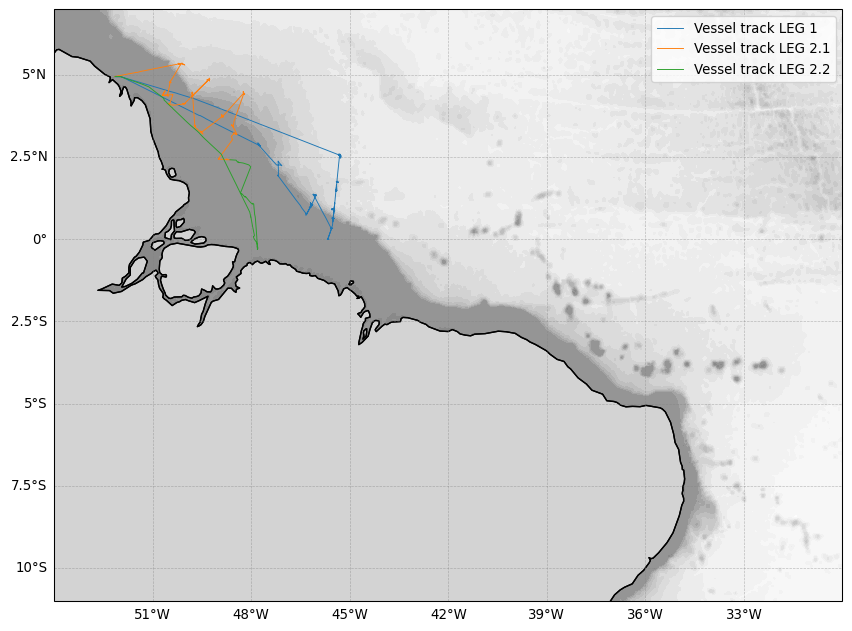

In [ ]:
# Plot map of the survey
img_file = f"output/figures/{EI}_survey_map.png"
if not os.path.isfile(img_file) or FORCE_PLOT:
    plot_survey_map(ds, outfile=img_file)
img = Image.open(img_file)
img

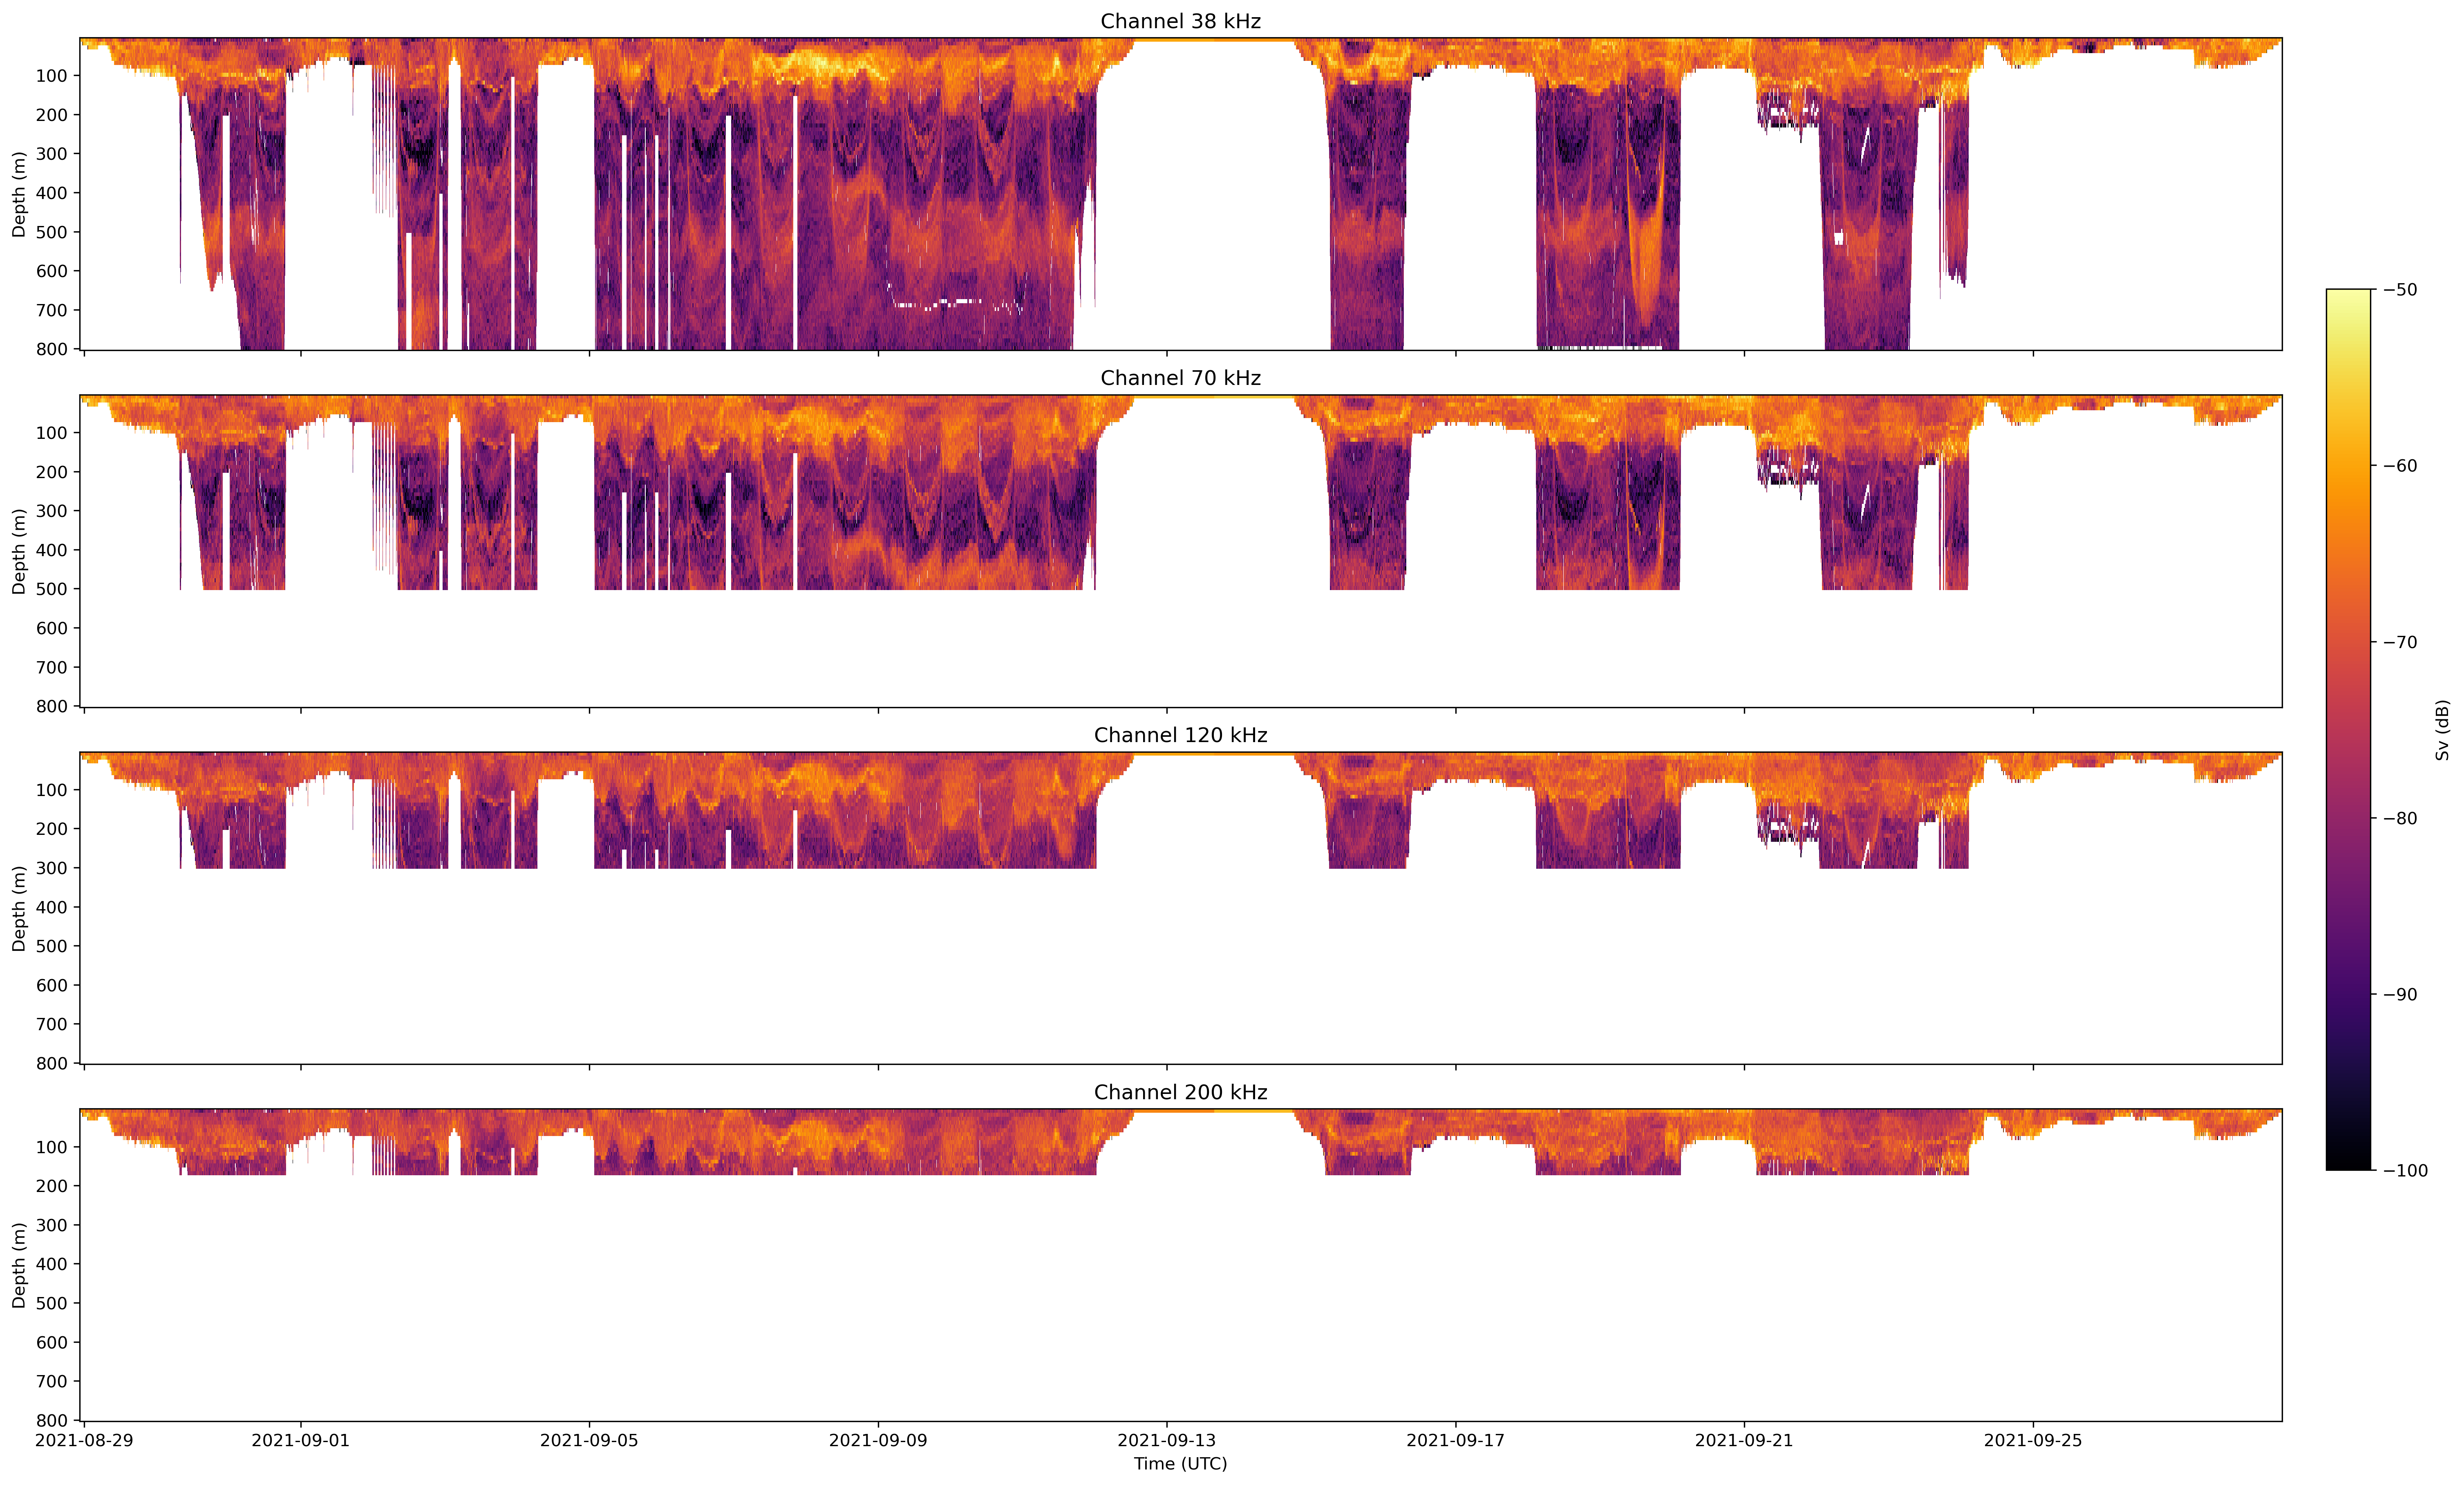

In [ ]:
outfile = f"output/figures/{EI}_4Cfacet.png"
if not os.path.isfile(outfile) or FORCE_PLOT:
    plot_sv_channels_faceted(
        ds["Sv"],
        outfile=outfile,
        cmap="inferno",
        figsize=(20, 12),
        vmin=-100,
        vmax=-50,
        sample_pixels=10_000_000
    )
img = Image.open(outfile)
img

# Show Sv distributions

In [17]:
FORCE_PLOT = True

In [18]:
# Get valid Sv values as xarray.DataArray and print maximum valid depth per channel
sv = ds_to_sv(ds, sv_threshold=SV_THRESHOLD)
valid = ~np.isnan(sv)
valid_any = valid.any(dim=[d for d in sv.dims if d not in ("depth", "channel")])
valid_depths = sv["depth"].where(valid_any)
max_valid_depth = valid_depths.max(dim="depth", skipna=True)

for c in max_valid_depth['channel'].values:
    print(f"Max valid depth for channel {c} kHz:\t{float(max_valid_depth.sel(channel=c))} meters.")

Max valid depth for channel 38.0 kHz:	799.5 meters.
Max valid depth for channel 70.0 kHz:	499.5 meters.
Max valid depth for channel 120.0 kHz:	299.5 meters.
Max valid depth for channel 200.0 kHz:	175.5 meters.


Max valid depth for channel 38.0 kHz:	799.5 meters.
Max valid depth for channel 70.0 kHz:	499.5 meters.
Max valid depth for channel 120.0 kHz:	299.5 meters.
Max valid depth for channel 200.0 kHz:	175.5 meters.


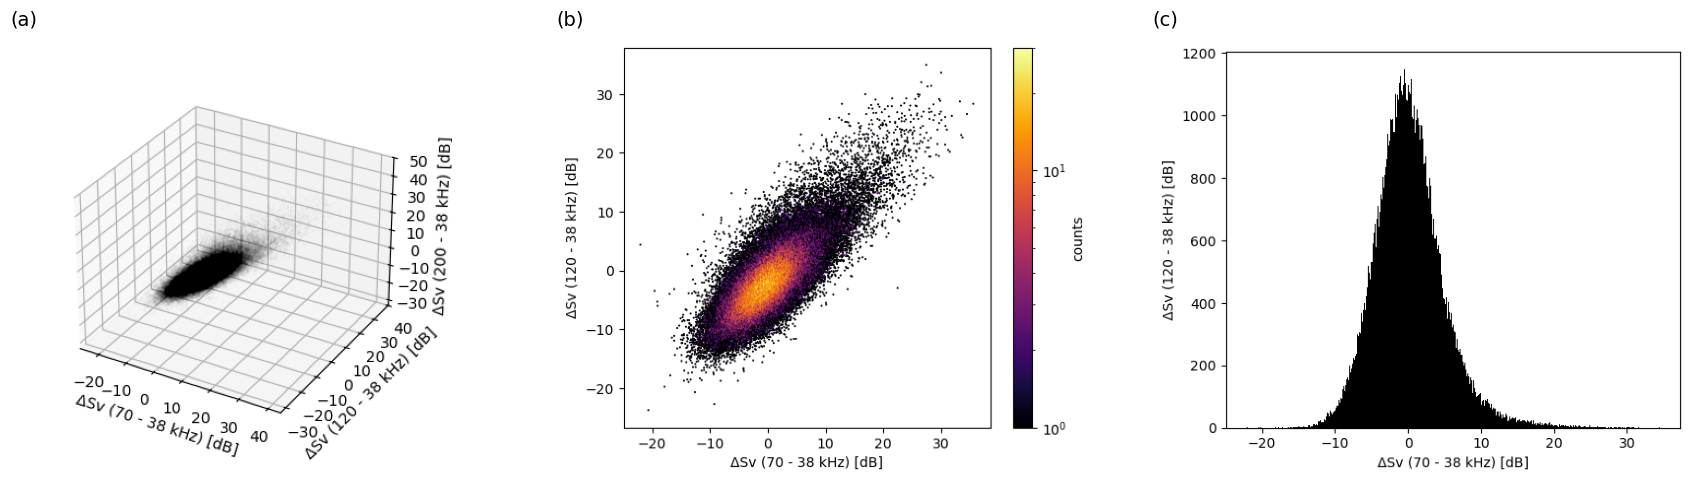

In [ ]:
FIGSIZE = (6, 5)
REF_FREQ = 38.

# Get valid Sv values as xarray.DataArray and print maximum valid depth per channel
sv = ds_to_sv(ds, sv_threshold=SV_THRESHOLD)
valid = ~np.isnan(sv)
valid_any = valid.any(dim=[d for d in sv.dims if d not in ("depth", "channel")])
valid_depths = sv["depth"].where(valid_any)
max_valid_depth = valid_depths.max(dim="depth", skipna=True)

for c in max_valid_depth['channel'].values:
    print(f"Max valid depth for channel {c} kHz:\t{float(max_valid_depth.sel(channel=c))} meters.")

# 3D scatterplot
max_freq = 200.
max_depth = float(max_valid_depth.sel(channel=max_freq))

sv = filter_depth(sv, max_depth)
ch_list = get_ch_list(sv, max_freq, ch_ref=REF_FREQ)
sv_diffs = compute_differences(sv, ch_ref=REF_FREQ, ch_list=ch_list)
flats = flatten_valid(*sv_diffs.values())
samples = sample_safe(*flats, n_samples=N_SAMPLES)

outfile = f"output/figures/{EI}_SvDiffDist_3D0-{max_depth}m_thresh{SV_THRESHOLD}_N{N_SAMPLES}.png"
if not os.path.isfile(outfile) or FORCE_PLOT:
    plot_3d_scatter(samples[0], samples[1], samples[2],
                    outfile=outfile,
                    figsize=FIGSIZE)

img_0 = Image.open(outfile)

# 2D hexbin plot in the 0 - 300 m depth range
max_freq = 120.
max_depth = float(max_valid_depth.sel(channel=max_freq))

sv = filter_depth(sv, max_depth)
ch_list = get_ch_list(sv, max_freq, ch_ref=REF_FREQ)
sv_diffs = compute_differences(sv, ch_ref=REF_FREQ, ch_list=ch_list)
flats = flatten_valid(*sv_diffs.values())
samples = sample_safe(*flats, n_samples=N_SAMPLES)

outfile = f"output/figures/{EI}_SvDiffDist_2D0-{max_depth}m_thresh{SV_THRESHOLD}_N{N_SAMPLES}.png"
if not os.path.isfile(outfile) or FORCE_PLOT:
    plot_hexbin_2d(samples[0], samples[1],
                    outfile=outfile,
                    figsize=FIGSIZE)

img_1 = Image.open(outfile)

# 1D histogram in the 0 - 500 m range
max_freq = 70.
max_depth = float(max_valid_depth.sel(channel=max_freq))

sv = filter_depth(sv, max_depth)
ch_list = get_ch_list(sv, max_freq, ch_ref=REF_FREQ)
sv_diffs = compute_differences(sv, ch_ref=REF_FREQ, ch_list=ch_list)
flats = flatten_valid(*sv_diffs.values())
samples = sample_safe(*flats, n_samples=N_SAMPLES)

outfile = f"output/figures/{EI}_SvDiffDist_2D0-{max_depth}m_thresh{SV_THRESHOLD}_N{N_SAMPLES}.png"
if not os.path.isfile(outfile) or FORCE_PLOT:
    plot_hist(samples[0],
              outfile=outfile,
              figsize=FIGSIZE)

img_2 = Image.open(outfile)


# Create a row of 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

images = [img_0, img_1, img_2]
labels = ['(a)', '(b)', '(c)']

for ax, img, label in zip(axes, images, labels):
    ax.imshow(img)
    ax.axis('off')  # Hide axes
    ax.set_title(label, loc='left', fontsize=14, pad=10)

plt.tight_layout()

combined_outfile = f"output/figures/{EI}_SvDiffDist_combined.png"
plt.savefig(combined_outfile, dpi=300)
plt.show()